In [11]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
import matplotlib.pyplot as plt


### Create Spark Session

In [13]:
spark = SparkSession.builder \
    .appName("EcommerceApp") \
    .config("spark.sql.warehouse.dir", "hdfs://localhost:9000/user/hive/warehouse") \
    .config("hive.metastore.uris", "thrift://localhost:9083") \
    .enableHiveSupport() \
    .getOrCreate()

#### Load data

In [17]:
spark.sql("use tradedb")
customers = spark.sql('select * from customers')
#customers = spark.read.csv("hdfs://localhost:9000/ecommerce/EcommerceCustomers.csv", header=True, inferSchema=True)
# Print DataFrame schema
customers.printSchema()
# Show first 5 rows of the DataFrame
customers.show(5, truncate=False)

root
 |-- email: string (nullable = true)
 |-- address: string (nullable = true)
 |-- avatar: string (nullable = true)
 |-- avgsessionlength: double (nullable = true)
 |-- timeonapp: double (nullable = true)
 |-- timeonwebsite: double (nullable = true)
 |-- lengthofmembership: double (nullable = true)
 |-- yearlyamountspent: double (nullable = true)

+-------------------------+-------------------+---------+------------------+------------------+------------------+------------------+-----------------+
|email                    |address            |avatar   |avgsessionlength  |timeonapp         |timeonwebsite     |lengthofmembership|yearlyamountspent|
+-------------------------+-------------------+---------+------------------+------------------+------------------+------------------+-----------------+
|Email                    |Address            |Avatar   |NULL              |NULL              |NULL              |NULL              |NULL             |
|mstephenson@fernandez.com|"835 Frank T

### Exploratory Data Analysis

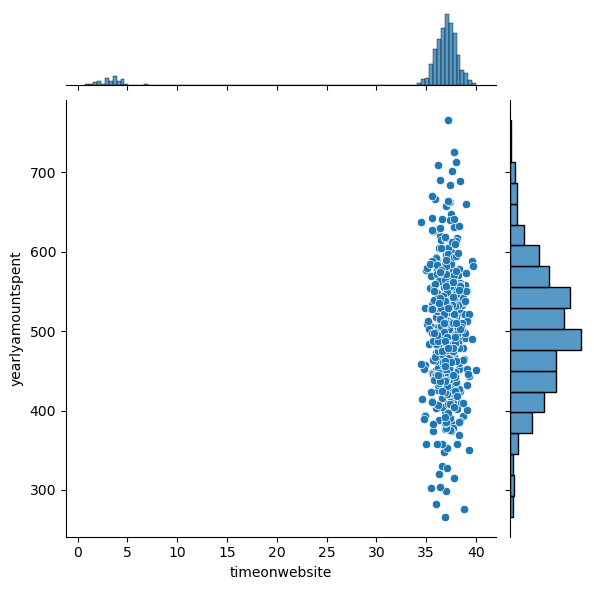

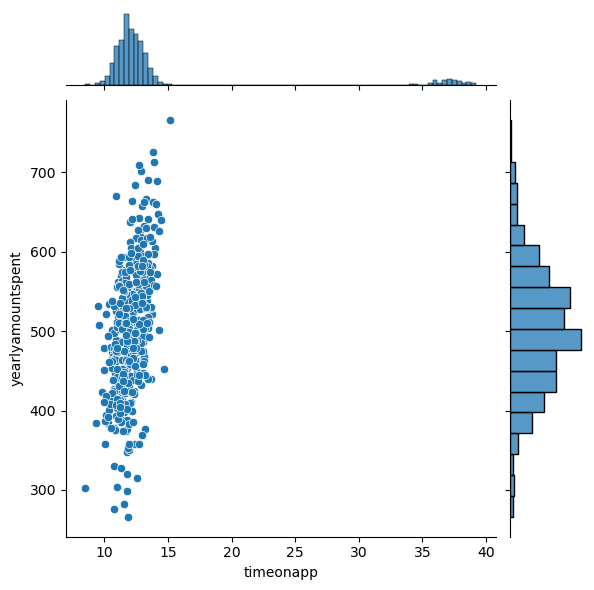

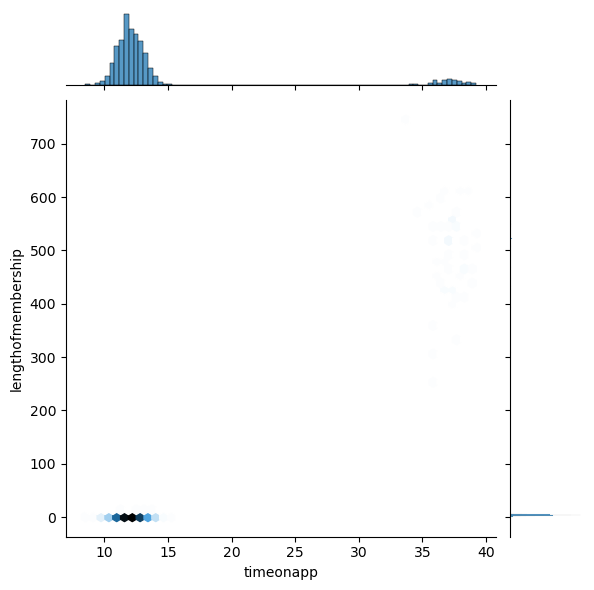

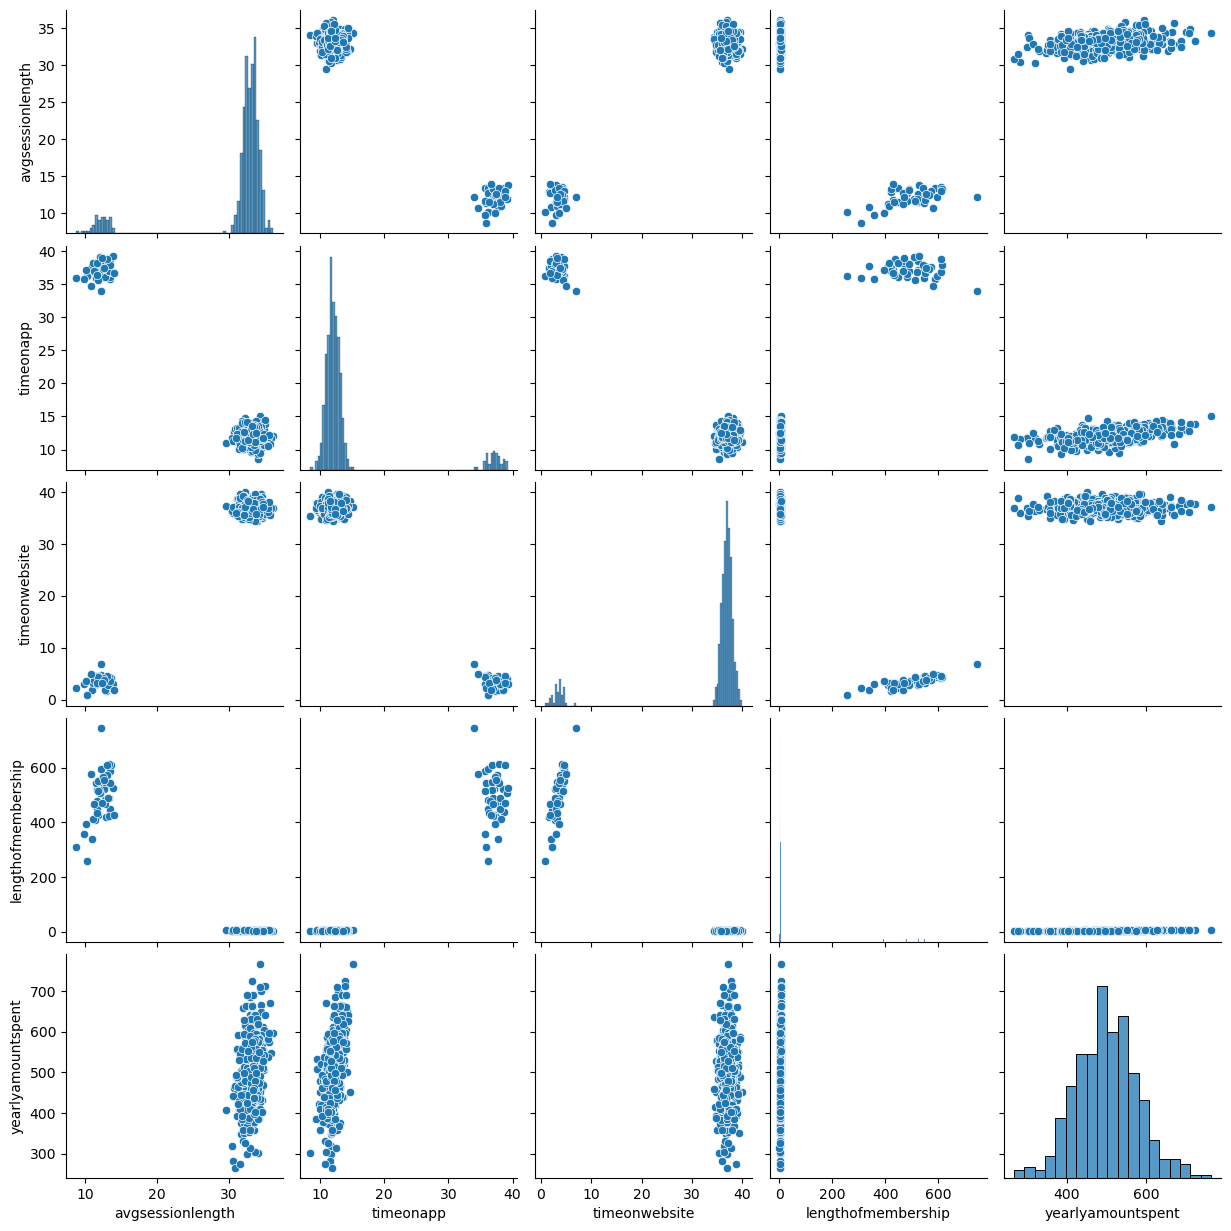

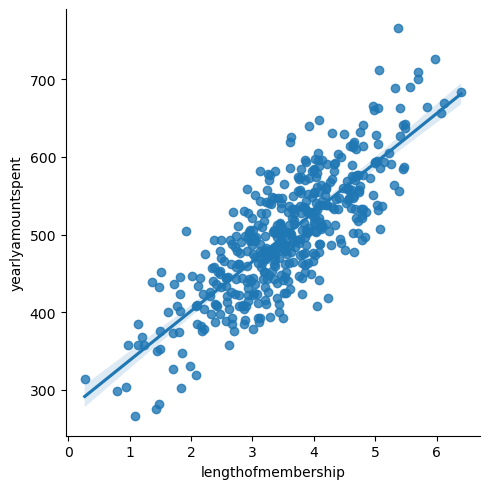

In [21]:
# Convert Spark DataFrame to Pandas for visualization
pandas_df = customers.toPandas()

# Create jointplots
import seaborn as sns

sns.jointplot(data=pandas_df, x='timeonwebsite', y='yearlyamountspent')
plt.show()

sns.jointplot(x='timeonapp', y='yearlyamountspent', data=pandas_df)
plt.show()

sns.jointplot(x='timeonapp', y='lengthofmembership', kind='hex', data=pandas_df)
plt.show()

sns.pairplot(pandas_df)
plt.show()

sns.lmplot(x='lengthofmembership', y='yearlyamountspent', data=pandas_df)
plt.show()

### Regression

In [30]:
# Prepare features
feature_columns = ['avgsessionlength', 'timeonapp', 'timeonwebsite', 'lengthofmembership']
target_column = 'yearlyamountspent'
customers_clean = customers.dropna(subset=feature_columns + [target_column])
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")
customers_assembled = assembler.transform(customers_clean)

# Split the data
(training_data, test_data) = customers_assembled.randomSplit([0.7, 0.3], seed=101)

# Create and train the model
lr = LinearRegression(featuresCol="features", labelCol="yearlyamountspent")
model = lr.fit(training_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="yearlyamountspent", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# Print coefficients and intercept
print("Coefficients: ")
for feature, coef in zip(feature_columns, model.coefficients):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept}")

# Calculate R-squared
r2 = model.summary.r2
print(f"R-squared: {r2}")



Root Mean Squared Error (RMSE) on test data = 9.814317885355385
Coefficients: 
avgsessionlength: 25.29239421131743
timeonapp: 38.62324191319326
timeonwebsite: 0.9915383202982081
lengthofmembership: 61.92785302256768
Intercept: -1057.6711759584716
R-squared: 0.9834646897144949


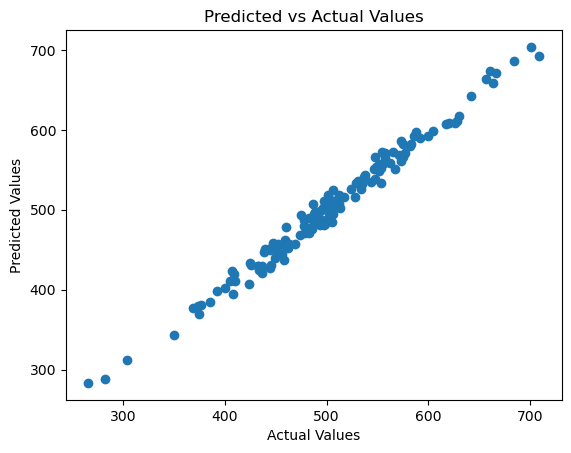

In [31]:
# Visualize predictions vs actual
pandas_predictions = predictions.select("yearlyamountspent", "prediction").toPandas()
plt.scatter(pandas_predictions["yearlyamountspent"], pandas_predictions["prediction"])
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()